# 1 Dataset and Task
 (a) Select your choice of neural networks model that is suitable for this task and motivate it. Train your model
 to predict one step ahead data point, during training (see following Figure). Scale your data before training
 and scale them back to be able to compare your predictions with real measurements.
 
 (b) How many past time steps should you input into your network to achieve the best possible performance?
 (Hint: This is a tunable parameter and needs to be tuned).
 
 (c) Once your model is trained, use it to predict the next 200 data points recursively. This means feeding each
 prediction back into the model to generate the subsequent predictions.)
 
 (d) On May 9th, download the real test dataset and evaluate your model by reporting both the Mean Absolute
 Error (MAE) and Mean Squared Error (MSE) between its predictions and the actual test values. Additionally,
 create a plot comparing the predicted and real values to visually assess your models performance.

First, we load the data and take a look at it. We also install torch:

Data shape: (1000, 1)
Data type: uint8
Min value: 2
Max value: 255


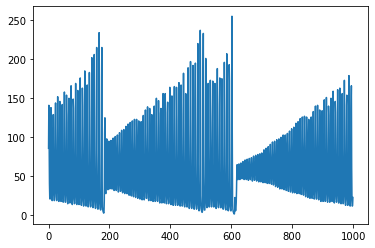

In [14]:
file = 'Xtrain.mat'
# load training data
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Load the training data
data = scipy.io.loadmat(file)
X_train = data['Xtrain']

# Display basic information about the data
print(f"Data shape: {X_train.shape}")
print(f"Data type: {X_train.dtype}")
print(f"Min value: {np.min(X_train)}")
print(f"Max value: {np.max(X_train)}")

# plot the data
plt.plot(X_train)
plt.show()


Now, we scale the data, because then the network works better and faster. 
I also want to scale it back, so that it can get the right outputs.

In [15]:
import sklearn
from sklearn.preprocessing import StandardScaler

#let's scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train.reshape(-1, 1))

#We also want the scaled back data ready:
restored_data = scaler.inverse_transform(scaled_data)

# Printing the first few values of the scaled and restored data to check
print(f"First few scaled values:\n{scaled_data[:5]}")
print(f"First few restored values:\n{restored_data[:5]}")

#Display basic information about the data
print(f"Data shape: {scaled_data.shape}")
print(f"Data type: {scaled_data.dtype}")
print(f"Min value: {np.min(scaled_data)}")
print(f"Max value: {np.max(scaled_data)}")

First few scaled values:
[[ 0.55720154]
 [ 1.73111118]
 [ 0.74929585]
 [-0.40326998]
 [-0.8088024 ]]
First few restored values:
[[ 86.]
 [141.]
 [ 95.]
 [ 41.]
 [ 22.]]
Data shape: (1000, 1)
Data type: float64
Min value: -1.2356786270219065
Max value: 4.16430570013708


In [16]:
#Now we want to split the data so that we have validation data:
split_ratio = 0.8
split_point = int(len(scaled_data) * split_ratio)

train_data = scaled_data[:split_point]
val_data = scaled_data[split_point:]

#making tensors:
#tensor_of_data = torch.tensor(train_data)
#print(f"`Tensor of the data` is a {tensor_of_data.ndim}-d Tensor with shape: {tensor_of_data.shape}")

In [17]:
#Now we define the function that retrieves the sequences:
def create_sequences(data, seq_len):
    sequences = []
    labels = []
    for i in range(len(data) - seq_len):
        seq = data[i:i+seq_len]
        label = data[i+seq_len]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [18]:
X_train_seq, y_train = create_sequences(train_data, seq_len)
X_val_seq, y_val = create_sequences(val_data, seq_len)

# Convert to PyTorch tensors
X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val_seq = torch.tensor(X_val_seq, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

In [19]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_dataset = TensorDataset(X_train_seq, y_train)
val_dataset = TensorDataset(X_val_seq, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [22]:
#making the LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # use output from last time step
        out = self.fc(out)
        return out

In [31]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
seq_len = 10 # try different ones

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), y_batch.squeeze())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch.squeeze())
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss/len(train_loader):.4f} - Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1/10 - Train Loss: 0.9750 - Val Loss: 0.9667
Epoch 2/10 - Train Loss: 0.8971 - Val Loss: 0.8892
Epoch 3/10 - Train Loss: 0.8327 - Val Loss: 0.7127
Epoch 4/10 - Train Loss: 0.5416 - Val Loss: 0.2889
Epoch 5/10 - Train Loss: 0.3591 - Val Loss: 0.1371
Epoch 6/10 - Train Loss: 0.2615 - Val Loss: 0.1101
Epoch 7/10 - Train Loss: 0.2310 - Val Loss: 0.0928
Epoch 8/10 - Train Loss: 0.1886 - Val Loss: 0.0642
Epoch 9/10 - Train Loss: 0.1663 - Val Loss: 0.0413
Epoch 10/10 - Train Loss: 0.1412 - Val Loss: 0.0192
